#**Data Science Challenge: Fraud Detection**

# 1. Introduction

## Bussiness challenge
Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices. Using historical transaction data, we aim to find patterns and build models to detect future fraud transactions.

## Data Overview

The dataset is credit card transactions data stored in line-delimited JSON format. It contains all transactions made on in 2016 (from 01/01/2016 to 12/31/2016). The dataset contains 786363 transaction records, which included 12417 Fraud transaction labled as True and 773946 normal transaction as False. Thus, the dataset is extremely imbalanced, the positive (fraud) class accounting for only 0.15% of all transaction.

# 2. Data Exploration

Before diving into the data, we need to import some libraies

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## General Data Exploration
First, we need to load the data and convert some variables to correct format, for example dates columns and blank values.

In [ ]:
#Please change this file path
data_path = '/content/drive/MyDrive/CapitalOne/transactions.txt' 

In [ ]:
df_raw = pd.read_json(data_path, lines=True)
df = df_raw.replace(r'\s+',np.nan,regex=True).replace('',np.nan)
df[["transactionDateTime", "accountOpenDate", "dateOfLastAddressChange",'currentExpDate']] = df[["transactionDateTime", "accountOpenDate", "dateOfLastAddressChange",'currentExpDate']].apply(pd.to_datetime)
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,NaN,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,NaN,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,NaN,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,NaN,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


Now, let's see how many data we have and what type of data by using info(). I have summarized this info in the data overview

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             786363 non-null  int64         
 1   customerId                786363 non-null  int64         
 2   creditLimit               786363 non-null  int64         
 3   availableMoney            786363 non-null  float64       
 4   transactionDateTime       786363 non-null  datetime64[ns]
 5   transactionAmount         786363 non-null  float64       
 6   merchantName              272715 non-null  object        
 7   acqCountry                781801 non-null  object        
 8   merchantCountryCode       785639 non-null  object        
 9   posEntryMode              782309 non-null  object        
 10  posConditionCode          785954 non-null  object        
 11  merchantCategoryCode      767399 non-null  object        
 12  cu

The raw dataset has 786363 entries with 28 attributes and one response variable.

We noticed that, columns "echoBuffer", "merchantCity", "merchantState", "merchantZip", "posOnPremises", "recurringAuthInd" contains all missing values, so we can immidiatly drop these columns.


In [ ]:
df = df.drop(columns=['echoBuffer', 'merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'])

Since we also noticed that some other attributes have missing values, we now need to check if how much missing data they contain

In [ ]:
print('Data columns with null values:\n', df.isna().sum())

Data columns with null values:
 accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                513648
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode         18964
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
currentBalance                   0
cardPresent                      0
expirationDateKeyInMatch         0
isFraud                          0
dtype: int64


Half of the transaction is missing "merchantName", but we can not drop the column now since the data is extremely imbalanced, so we might find other way to transform it. Similar situation for other attributes, we can not just drop record with missing data immediately since we might loss some important information.

Then, we explore the distribution of numerical attributes:


In [ ]:
df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000


Here, we only need to focus on creditLimit, availableMoney, transactionAmount, currentBalance since others are qualitative and their distribution has no meaning. We noticed that, these numerical values have very different range, so we might need to perform Standardization during data cleaning step

Next, we see the distribution of categorical data


In [ ]:
df.describe(include=['object', 'bool'])

,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,isFraud
count,272715,781801,785639,782309,785954,767399,785665,786363,786363,786363
unique,29,4,4,5,3,18,3,2,2,2
top,Uber,US,US,05,01,online_retail,PURCHASE,False,False,False
freq,25613,774709,778511,315035,628787,202156,745193,433495,785320,773946


See different values of categorical data

In [ ]:
cat_attributes = df.select_dtypes(include=['object']).columns
for col in cat_attributes:
  print(col)
  print(df[col].unique())

merchantName
['Uber' nan 'GreenCook' 'staples.com' 'target.com' 'amazon.com' 'gap.com'
 'sears.com' 'apple.com' 'oldnavy.com' 'ebay.com' 'discount.com'
 'alibaba.com' 'Lyft' 'cheapfast.com' 'walmart.com' 'Spotify' 'abc.com'
 'hulu.com' 'netflix.com' 'ethanallen.com' 'Wayfair.com'
 'pottery-barn.com' 'Aloft' 'ashleyfurniture.com' 'ikea.com' 'westelm.com'
 'williamssonoma.com' 'MyApron' 'DailyOmnivore']
acqCountry
['US' nan 'CAN' 'MEX' 'PR']
merchantCountryCode
['US' 'CAN' nan 'PR' 'MEX']
posEntryMode
['02' '09' '05' '80' '90' nan]
posConditionCode
['01' '08' '99' nan]
merchantCategoryCode
['rideshare' 'entertainment' 'mobileapps' 'fastfood' 'food_delivery'
 'auto' 'online_retail' 'gym' 'health' nan 'food' 'fuel'
 'online_subscriptions' 'online_gifts' 'hotels' 'airline' 'furniture'
 'subscriptions' 'cable/phone']
transactionType
['PURCHASE' 'ADDRESS_VERIFICATION' 'REVERSAL' nan]


Categorical data does not have ranking meaning and their unique values are pretty small, so we can transform them using one hot encoding during the cleaning process

## Target Exploration
Now let's take closer look at our target variable isFraud by first plot a histogram of the processed amounts of each transaction, the transactionAmount column.

In [ ]:
df['isFraud'].value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [ ]:
df['isFraud'].value_counts(normalize=True)

False    0.98421
True     0.01579
Name: isFraud, dtype: float64

As I mentioned in the data overview, our dataset is extrmely imblanced with only 0.15% positive (fraud) class accounting

## Data exploration visulization

### Transaction amount

Based on the knowledge from our stakeholders, the transaction amount might have some influence on our response variable, we will dig a little deeper into this artribute by first plotting a histogram of the processed amounts of each transaction, the transactionAmount column

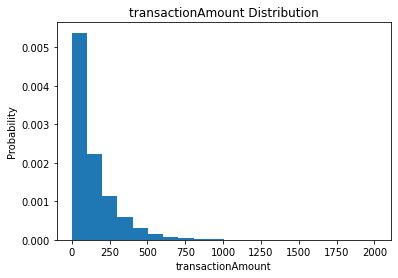

In [ ]:
transactionAmount = df['transactionAmount'].values
plt.hist(transactionAmount, density=True, bins=20)  # density=False would make counts
plt.title("transactionAmount Distribution")
plt.ylabel('Probability')
plt.xlabel('transactionAmount');

Based on the histogram, most of the transactions in the dataset have the transactionAmount smaller than \$500 and the transaction amount of all records are no greater than \$1000. 

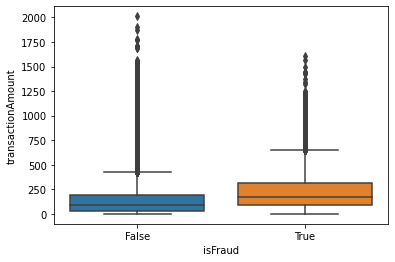

In [ ]:
sns.boxplot(x = 'isFraud', y = 'transactionAmount', data=df)

Using this box plot, we can see Fraud transactions are generally greater than normal transaction. Fraud transactions are more variate than normal transaction

# 3. Data Wrangling



## Duplicate Transactions

I noticed a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

### Reversal transaction

This type of duplicated transaction are already classified in the "transactionType columns". So to identify them, we can simply select all transactions that have "transactionType" as REVERSAL

In [ ]:
df_reversal = df[df['transactionType']=='REVERSAL']
print('There are ', df_reversal.shape[0],' reversal transactions in this dataset')
print('The total dollar amount estimated for the reversed transactions is $',df_reversal['transactionAmount'].sum())

There are  20303  reversal transactions in this dataset
The total dollar amount estimated for the reversed transactions is $ 2821792.5


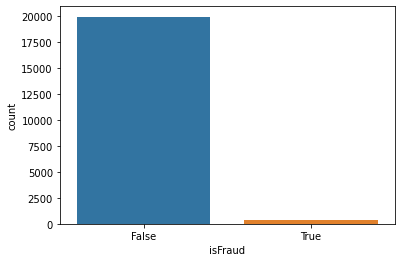

In [ ]:
ax = sns.countplot(x='isFraud', data= df_reversal)

### Multi-swipe transactions

For multi-swipe transactions, things are little trickier since those transactions are not labled like reversal transaction, so we need to group transaction by account number and transactionAmount during short time span to identify this type of duplicate transactions. Here I assumed the short time span is 120 seconds

In [ ]:
df['Duplicated'] = (df.sort_values(['transactionDateTime'])
                       .groupby(['accountNumber', 'transactionAmount'], sort=False)['transactionDateTime']
                       .diff().dt.total_seconds().lt(120))

In [ ]:
df_dup = df[df['Duplicated'] == True]
print('There are ', df_dup.shape[0],' multi-swipe transactions in this dataset')
print('The total dollar amount estimated for the multi-swipe transactions is $',df_dup['transactionAmount'].sum())

There are  8882  multi-swipe transactions in this dataset
The total dollar amount estimated for the multi-swipe transactions is $ 1304345.4100000001


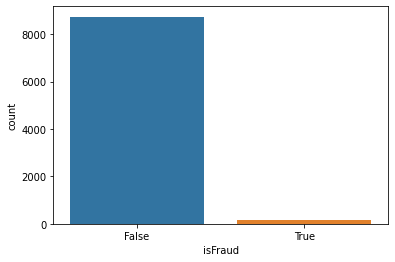

In [ ]:
ax = sns.countplot(x='isFraud', data= df_dup)

### Findings about duplicated transaction

The data contains only small amout of duplicate transactions comparing to the whole dataset. Based on the distribution of fraud in those cases, there is not so much important information. Thus, beside removing those duplicated transaction, we can remove the transactionType attribute.

## Data Cleaning

First we remove duplicated transaction and duplicate data as well

In [ ]:
df_clean = df.copy()

In [ ]:
df_clean.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Duplicated
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,NaN,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,False
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,NaN,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,False
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,NaN,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,False
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,NaN,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False,False


In [ ]:
df_clean = df_clean.drop_duplicates()
df_clean = df_clean.dropna(subset=['transactionType'])
df_clean = df_clean[df_clean['transactionType'] != 'REVERSAL'] #Drop reversal transaction
df_clean = df_clean[df_clean['Duplicated'] == False] #Drop mutiple transaction
df_clean = df_clean.drop(columns=['Duplicated'])

We double check the distribution of transactionType attribute

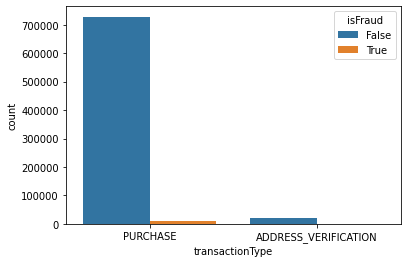

In [ ]:
sns.countplot(data=df_clean, x='transactionType', hue='isFraud')

We can see that this attribute is no longer useful so we can drop it

In [ ]:
df_clean = df_clean.drop(columns=['transactionType'])

We also noticed that accountNumber and customerId are identical and no longer useful for our classification, so we can now drop them

In [ ]:
df_clean = df_clean.drop(columns=['accountNumber','customerId'])

Now, we hanle date time attribute by transform it to more meaningful attributes, for instance, we transform accountOpenDate to accountAge, dateOfLastAddressChange to monthsLastAddressChange, currentExpDate to dayleft, then drop those old datetime attributes. For the transactionDateTime, I have tried to extract the date and month of that attributes, but it does not have any impact on the model so I will remove it. 

In [ ]:
#Transform accountOpenDate to account Age in 01-01-2017
currentExpDate = pd.to_datetime('2017-01-01')
df_clean['accountAge'] = currentExpDate - df_clean['accountOpenDate']
df_clean['accountAge']= round(df_clean['accountAge']/np.timedelta64(1,'D')).astype(int)

#Transform dateOfLastAddressChange to monthsLastAddressChange
df_clean['monthsLastAddressChange'] = currentExpDate - df_clean['dateOfLastAddressChange']
df_clean['monthsLastAddressChange']= round(df_clean['monthsLastAddressChange']/np.timedelta64(1,'D')).astype(int)

#Transform currentExpDate to day left
df_clean['currentToExpDate'] = df_clean['currentExpDate'] - currentExpDate 
df_clean['currentToExpDate']= round(df_clean['currentToExpDate']/np.timedelta64(1,'D')).astype(int)
#df.head()

#Drop col 
df_clean = df_clean.drop(columns=['accountOpenDate','dateOfLastAddressChange','currentExpDate','transactionDateTime'])

Now we transform cardCVV, enteredCVV to wrong cvv

In [ ]:
df_clean['wrongCVV'] = df_clean['enteredCVV'] - df_clean['cardCVV']
df_clean['wrongCVV'] = np.where(df_clean.wrongCVV != 0, True, False)

In [ ]:
df_clean = df_clean.drop(columns=['enteredCVV','cardCVV'])

We drop the cardLast4Digits, since it is a nomial attribute 

In [ ]:
df_clean = df_clean.drop(columns=['cardLast4Digits'])

Transform merchantName as hasMerchantName since as I mentioned above, this attribute is half missing

In [ ]:
df_clean['haveMerchantName'] = np.where(df_clean.merchantName.isna(), False, True)
df_clean = df_clean.drop(columns='merchantName')

Handle others nan atrbibute by labled them as unknown

In [ ]:
df_clean['merchantCategoryCode'] = df_clean['merchantCategoryCode'].replace(np.nan, "unknown")
df_clean['acqCountry'] = df_clean['acqCountry'].replace(np.nan, "unknown")
df_clean['merchantCountryCode'] = df_clean['merchantCountryCode'].replace(np.nan, "unknown")
df_clean['posEntryMode'] = df_clean['posEntryMode'].replace(np.nan, "unknow")
df_clean['posConditionCode'] = df_clean['posConditionCode'].replace(np.nan, "unknow")

explore others attribute that is not clear like expirationDateKeyInMatch

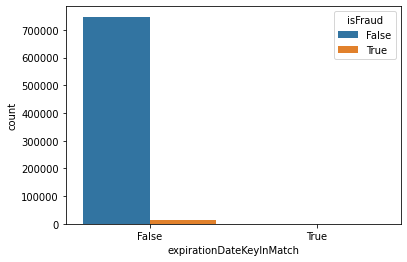

In [ ]:
sns.countplot(data=df_clean, x='expirationDateKeyInMatch', hue='isFraud')

In [ ]:
df_clean = df_clean[['creditLimit', 'availableMoney', 'transactionAmount', 'haveMerchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentBalance',
       'cardPresent', 'expirationDateKeyInMatch', 'accountAge',
       'monthsLastAddressChange', 'currentToExpDate', 'wrongCVV','isFraud']]
df_clean.head()

,creditLimit,availableMoney,transactionAmount,haveMerchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentBalance,cardPresent,expirationDateKeyInMatch,accountAge,monthsLastAddressChange,currentToExpDate,wrongCVV,isFraud
0,5000,5000.0,98.55,True,US,US,02,01,rideshare,0.0,False,False,659,659,2342,False,False
1,5000,5000.0,74.51,False,US,US,09,01,entertainment,0.0,True,False,659,659,2587,False,False
2,5000,5000.0,7.47,False,US,US,09,01,mobileapps,0.0,False,False,659,659,3134,False,False
3,5000,5000.0,7.47,False,US,US,09,01,mobileapps,0.0,False,False,659,659,3134,False,False
4,5000,5000.0,71.18,False,US,US,02,01,fastfood,0.0,True,False,514,514,4656,False,False


Stored the df

In [ ]:
# df_clean.to_csv( "/content/drive/MyDrive/CapitalOne/transactions_cleanned.csv", index=False, encoding='utf-8-sig')

# 4. EDA

Now, we will see if those attributes related to our response so we can filter more unrelated attributes

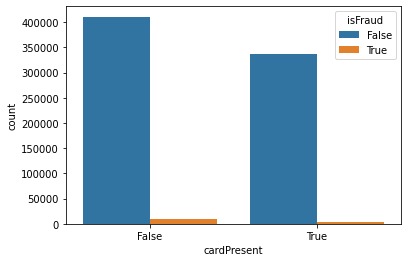

In [ ]:
sns.countplot(data=df_clean, x='cardPresent', hue='isFraud')

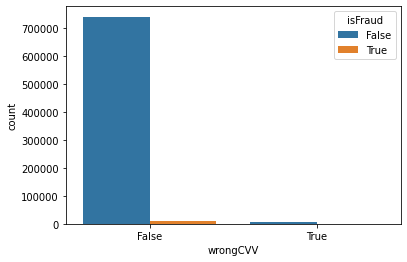

In [ ]:
sns.countplot(data=df_clean, x='wrongCVV', hue='isFraud')

wrongCVV seems not to work

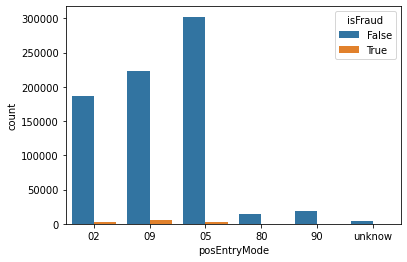

In [ ]:
sns.countplot(data=df_clean, x='posEntryMode', hue='isFraud')

Most of entry methods are 02, 09, 05

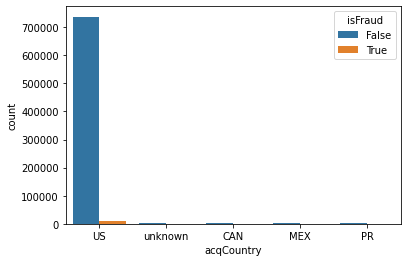

In [ ]:
sns.countplot(data=df_clean, x='acqCountry', hue='isFraud')

acqCountry also does not work

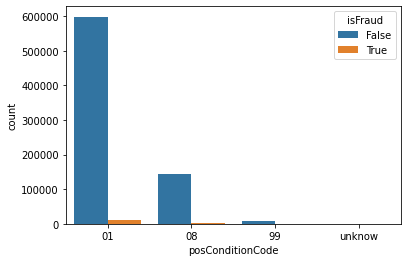

In [ ]:
sns.countplot(data=df_clean, x='posConditionCode', hue='isFraud')

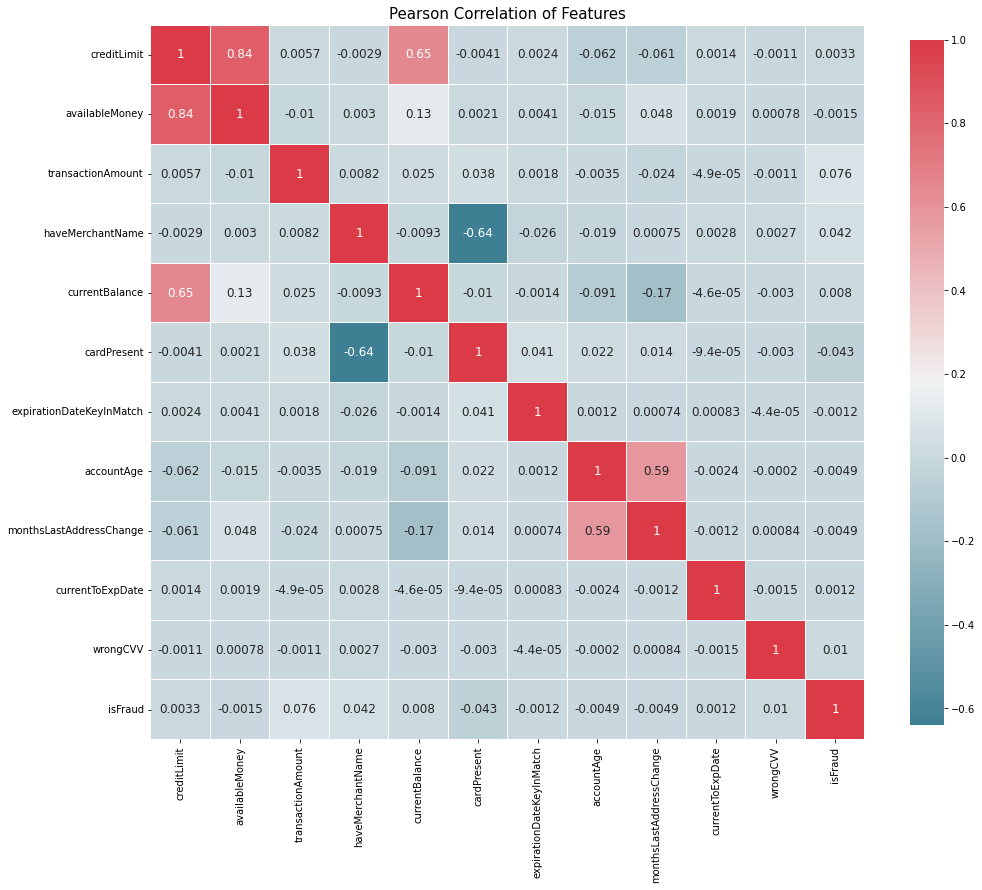

In [ ]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(16, 14))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df_clean)

Based on this graph and previous histogram plots we can drop that creditLimit availableMoney, acqCountry, and wrongCVV

In [ ]:
df_clean = df_clean.drop(columns=['creditLimit','availableMoney','acqCountry','wrongCVV'])

Overall we can see the main problem is that, the data is unbalanced,...
We will build model to around t

# 5. Model

In this section, I will implement different predictive model to determine whether a given transaction will be fraudulent or not. This is a binary classification problem. Since the dataset is extremely unblanced, with limited time, I will focus on Decision Tree models and its relative such as Random Forests, XGBoost, and LightGBM.

## Transform data

The first step is to make our dataset more machine learning ready by encoding categorical attributes and normalize numerical attributes

In [ ]:
df_ml = df_clean.copy()
df_ml.head()

,transactionAmount,haveMerchantName,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentBalance,cardPresent,expirationDateKeyInMatch,accountAge,monthsLastAddressChange,currentToExpDate,isFraud
0,98.55,True,US,02,01,rideshare,0.0,False,False,659,659,2342,False
1,74.51,False,US,09,01,entertainment,0.0,True,False,659,659,2587,False
2,7.47,False,US,09,01,mobileapps,0.0,False,False,659,659,3134,False
3,7.47,False,US,09,01,mobileapps,0.0,False,False,659,659,3134,False
4,71.18,False,US,02,01,fastfood,0.0,True,False,514,514,4656,False


Encode (convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns.) categorical attributes using get_dummies

In [ ]:
df_ml = pd.get_dummies(df_ml, columns=['merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode'])

Then, we transform bolean attribute to 1-0 

In [ ]:
df_ml["cardPresent"] = df_ml["cardPresent"].astype(int)
df_ml["expirationDateKeyInMatch"] = df_ml["expirationDateKeyInMatch"].astype(int)
df_ml["haveMerchantName"] = df_ml["haveMerchantName"].astype(int)
# df_ml["wrongCVV"] = df_ml["wrongCVV"].astype(int)
df_ml["isFraud"] = df_ml["isFraud"].astype(int)


In [ ]:
df_ml.head()

,transactionAmount,haveMerchantName,currentBalance,cardPresent,expirationDateKeyInMatch,accountAge,monthsLastAddressChange,currentToExpDate,isFraud,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,merchantCountryCode_unknown,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posEntryMode_unknow,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_unknow,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,merchantCategoryCode_unknown
0,98.55,1,0.0,0,0,659,659,2342,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,74.51,0,0.0,1,0,659,659,2587,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7.47,0,0.0,0,0,659,659,3134,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,7.47,0,0.0,0,0,659,659,3134,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,71.18,0,0.0,1,0,514,514,4656,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Finally, we split the data into training and testing data. Here I will split 80% for training set and 20% for testing

In [ ]:
from sklearn.model_selection import train_test_split

X = df_ml.drop('isFraud', axis=1)
y = df_ml['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)

Standardize numerical attributes (mean as 0 and standard deviation as 1) using StandardScaler. We will fit on the training set and transform it for both training and testing to avoid data leakage

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_col_names = ['transactionAmount','currentBalance','accountAge','monthsLastAddressChange','currentToExpDate']
num_features = X_train[num_col_names]
test_num_features = X_test[num_col_names]

ct = ColumnTransformer([
        ('somename', StandardScaler(), ['transactionAmount', 'currentBalance','accountAge','monthsLastAddressChange','currentToExpDate'])
    ], remainder='passthrough')

features = ct.fit_transform(num_features)
test_feature = ct.transform(test_num_features)
X_train[num_col_names] = features
X_test[num_col_names] = test_feature

## Models

In [ ]:
# Import some evaluation functions
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix

In [ ]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

In [ ]:
models = ['DT','RF','XGB','LGBM']
balanced_accuracy = []

### Decision Tree

First, we will try to implement the most basic model - decision tree.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    149625
           1       0.07      0.06      0.06      2438

    accuracy                           0.97    152063
   macro avg       0.53      0.52      0.52    152063
weighted avg       0.97      0.97      0.97    152063



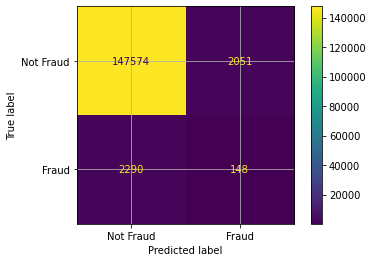

In [ ]:
from sklearn.tree import DecisionTreeClassifier         
weights = {0:0.01, 1:9.99}
decision_tree_model = DecisionTreeClassifier(class_weight=weights)
decision_tree_model.fit(X_train, y_train)
dt_pred = decision_tree_model.predict(X_test)

plot_confusion_matrix(decision_tree_model, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, dt_pred, zero_division=0))

balanced_accuracy.append(balanced_accuracy_score(y_test, dt_pred))

Although the accuracy is high, the low 0.05 recall score on the 1 label show that the True positve is very low. In this problem, we should focus more on transaction that high true positive. 

### Random Forest

Random Forest is...

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    149625
           1       0.41      0.00      0.01      2438

    accuracy                           0.98    152063
   macro avg       0.70      0.50      0.50    152063
weighted avg       0.97      0.98      0.98    152063



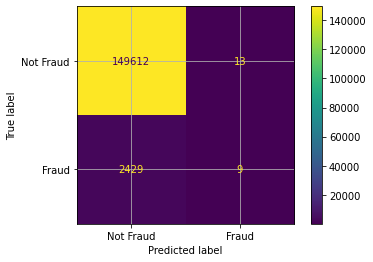

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

plot_confusion_matrix(rf, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, rf_pred, zero_division=0))

balanced_accuracy.append(balanced_accuracy_score(y_test, rf_pred))

### XGBoost

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    149625
           1       0.00      0.00      0.00      2438

    accuracy                           0.98    152063
   macro avg       0.49      0.50      0.50    152063
weighted avg       0.97      0.98      0.98    152063



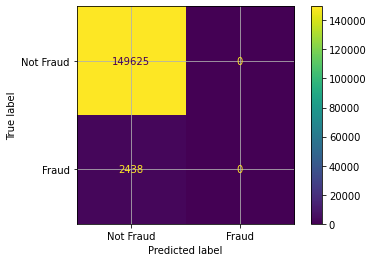

In [ ]:
# xgb = XGBClassifier(scale_pos_weight=98)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

plot_confusion_matrix(xgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, xgb_pred, zero_division=0))

balanced_accuracy.append(balanced_accuracy_score(y_test, xgb_pred))

### LightGBm

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgb = LGBMClassifier(
          # max_bin = 63,
          max_depth = 63, num_leaves = 255, num_iterations = 500,
          learning_rate = 0.01, tree_learner = 'serial', is_dfing_metric = False,
          min_data_in_leaf = 1, min_sum_hessian_in_leaf = 100, sparse_threshold=1.0,
          # device = 'gpu',
          num_thread = -1, save_binary= True, seed= 42, feature_fraction_seed = 42,
          bagging_seed = 42, drop_seed = 42, data_random_seed = 42,
          objective = 'binary', boosting_type = 'gbdt',
          verbose = 1, metric = 'auc',is_unbalance = True,
          # scale_pos_weight = 98,
          boost_from_average = False,
)

              precision    recall  f1-score   support

           0       1.00      0.79      0.88    598697
           1       0.07      0.91      0.12      9552

    accuracy                           0.79    608249
   macro avg       0.53      0.85      0.50    608249
weighted avg       0.98      0.79      0.87    608249



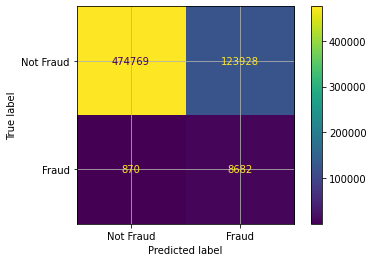

In [ ]:
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict(X_train)
plot_confusion_matrix(lgb, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_train, lgb_train_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88    149625
           1       0.05      0.68      0.09      2438

    accuracy                           0.79    152063
   macro avg       0.52      0.73      0.49    152063
weighted avg       0.98      0.79      0.87    152063



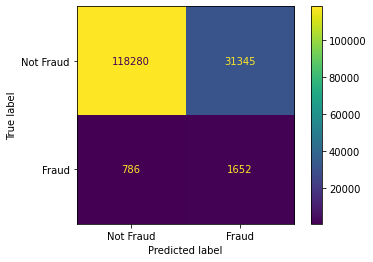

In [ ]:
lgb_pred = lgb.predict(X_test)

plot_confusion_matrix(lgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
print(classification_report(y_test, lgb_pred, zero_division=0))

balanced_accuracy.append(balanced_accuracy_score(y_test, lgb_pred))

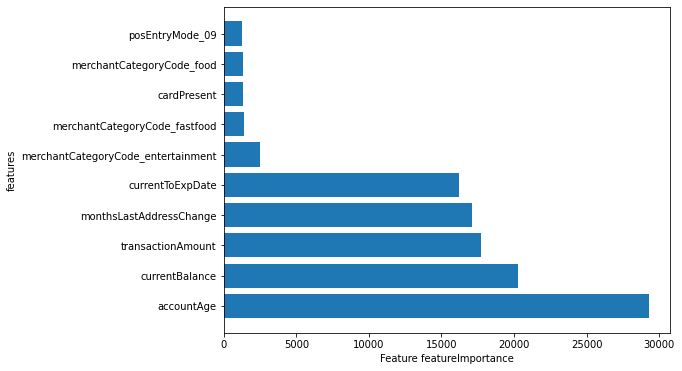

In [ ]:
# print the feature importance
features = X.columns
feature_imp = lgb.feature_importances_

feature_imp_df = pd.DataFrame({'features' : features, 'featureImportance' : feature_imp}).sort_values(by='featureImportance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(8,6))
plt.barh(y=feature_imp_df['features'].iloc[ : 10], width=feature_imp_df['featureImportance'].iloc[ : 10])
plt.xlabel("Feature featureImportance")
plt.ylabel("features")
plt.show()

We can see one of the extracted feature is very important

### Result

Since there are much more False labled, the model can just have high accuracy by predicting everything to be False, which is not good for this case since we want to idenitfy Fraud. Thus, I used Balanced accuracy, a metric that one can use when evaluating how good a binary classifier, especially useful when the classes are imbalance, to justify the performance of the models beside confusion matrix and others like recall, F-score, and precision. 

In [ ]:
balance_acc_tab = pd.DataFrame({'model' : models, 'acc' : balanced_accuracy })
print(balance_acc_tab)

  model       acc
0    DT  0.523499
1    RF  0.501802
2   XGB  0.500000
3  LGBM  0.734057


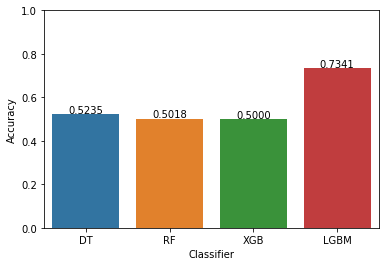

In [ ]:
axis = sns.barplot(x = 'model', y = 'acc', data = balance_acc_tab)
axis.set(xlabel='Classifier', ylabel='Accuracy')
axis.set(ylim=(0.0, 1.0))


for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

Based on the table and the graph, we can see that lightGBM model perform the best with highest balanced accuracy. Looking at its confusion matrix, its recall (True positive rate) also the highest among four models, which mean its can classified fraud transaction well in case of imbalanced data. We can also see that the lightGBM model is not overfitted by comparing its result on the training set and the test set.

## Model with under sample data

Undersample is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class. It is one of several techniques data scientists can use to extract more accurate information from originally imbalanced datasets. Here I impelemented the RandomUnderSampler from imblearn library to perform that technique.

### Undersample data

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 

In [ ]:
df_us = df_ml.copy() 
rus = RandomUnderSampler(sampling_strategy='not minority',random_state=34)
y = df_us['isFraud']
X = df_us.drop('isFraud', axis=1)
X_us, y_us = rus.fit_resample(X, y)
print(f'Data set size before Under Sampling: {X.shape}')
print(f'Data set size after Under Sampling: {X_us.shape}')


Data set size before Under Sampling: (760312, 42)
Data set size after Under Sampling: (23980, 42)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.20, random_state=33)

In [ ]:
models = ['DT','RF','XGB','LGBM']
accuracy = []

### Decision Tree

              precision    recall  f1-score   support

           0       0.69      0.67      0.68      2370
           1       0.69      0.70      0.70      2426

    accuracy                           0.69      4796
   macro avg       0.69      0.69      0.69      4796
weighted avg       0.69      0.69      0.69      4796



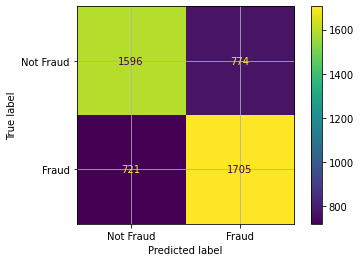

In [ ]:
decision_tree_model = DecisionTreeClassifier(max_depth=5)
decision_tree_model.fit(X_train, y_train)
y_pred = decision_tree_model.predict(X_test)

plot_confusion_matrix(decision_tree_model, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))
accuracy.append(accuracy_score(y_test, y_pred))

### Random Forest

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      2370
           1       0.71      0.72      0.72      2426

    accuracy                           0.71      4796
   macro avg       0.71      0.71      0.71      4796
weighted avg       0.71      0.71      0.71      4796



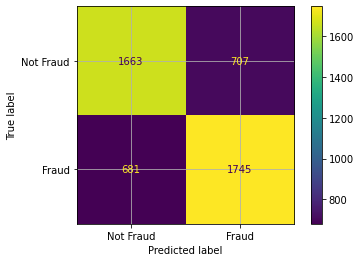

In [ ]:
rf = RandomForestClassifier()

# fit the predictor and target
rf.fit(X_train, y_train)
         
# predict
rf_pred = rf.predict(X_test)

plot_confusion_matrix(rf, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, rf_pred, zero_division=0))
accuracy.append(accuracy_score(y_test, rf_pred))

### XGBoost

              precision    recall  f1-score   support

           0       0.69      0.74      0.71      2370
           1       0.72      0.67      0.70      2426

    accuracy                           0.70      4796
   macro avg       0.70      0.70      0.70      4796
weighted avg       0.70      0.70      0.70      4796



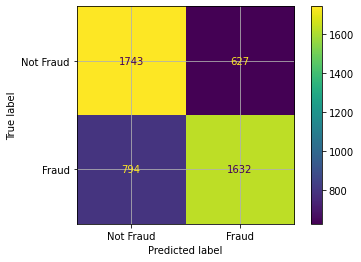

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

plot_confusion_matrix(xgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, xgb_pred, zero_division=0))
accuracy.append(accuracy_score(y_test, xgb_pred))

### LightGBM

In [ ]:
lgb = LGBMClassifier(
          max_bin = 63,
          # max_depth = 63,
          num_leaves = 255, num_iterations = 500, learning_rate = 0.01,
          tree_learner = 'serial', is_dfing_metric = False,
          min_data_in_leaf = 1, min_sum_hessian_in_leaf = 100, sparse_threshold=1.0,
          # device = 'gpu',
          num_thread = -1, save_binary= True, seed= 42,
          feature_fraction_seed = 42, bagging_seed = 42, drop_seed = 42,
          data_random_seed = 42, objective = 'binary',
          boosting_type = 'gbdt', verbose = 1, metric = 'auc',
          # is_unbalance = True,
          # scale_pos_weight = 98,
          boost_from_average = False,
)

lgb.fit(X_train, y_train)

LGBMClassifier(bagging_seed=42, boost_from_average=False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, data_random_seed=42,
               drop_seed=42, feature_fraction_seed=42, importance_type='split',
               is_dfing_metric=False, learning_rate=0.01, max_bin=63,
               max_depth=-1, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=1, min_split_gain=0.0,
               min_sum_hessian_in_leaf=100, n_estimators=100, n_jobs=-1,
               num_iterations=500, num_leaves=255, num_thread=-1,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, save_binary=True, seed=42, ...)

              precision    recall  f1-score   support

           0       0.69      0.67      0.68      2370
           1       0.69      0.70      0.70      2426

    accuracy                           0.69      4796
   macro avg       0.69      0.69      0.69      4796
weighted avg       0.69      0.69      0.69      4796



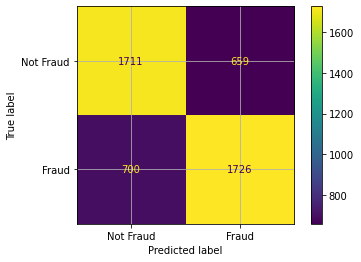

In [ ]:
lgb_pred = lgb.predict(X_test)

plot_confusion_matrix(lgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))
accuracy.append(accuracy_score(y_test, lgb_pred))

### Result

In [ ]:
acc_tab = pd.DataFrame({'model' : models, 'acc' : accuracy })
print(acc_tab)

  model       acc
0    DT  0.688282
1    RF  0.710592
2   XGB  0.703711
3  LGBM  0.716639


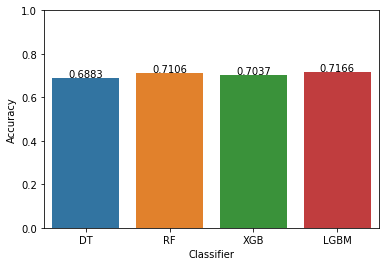

In [ ]:
axis = sns.barplot(x = 'model', y = 'acc', data = acc_tab)
axis.set(xlabel='Classifier', ylabel='Accuracy')
axis.set(ylim=(0.0, 1.0))


for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

With more balanced data, other models improved their performance except the lightGBM stays the same.

### Fine tune some models using grid search

GridsearchCV is exhaustive search over specified parameter values for an estimator. 

In [ ]:
from sklearn.model_selection import GridSearchCV

#### Decision Tree

In [ ]:
dt_clf = DecisionTreeClassifier()
params = {
    "criterion":['gini','entropy'],
    "max_depth": range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,5)
}

dt_grid = GridSearchCV(dt_clf, param_grid=params, cv = 10,verbose=1,n_jobs=-1,scoring='accuracy')
dt_grid.fit(X_train, y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3980 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5780 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  6.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                    

In [ ]:
print(dt_grid.best_params_)
print(dt_grid.best_score_)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 3}
0.6886449157511108


              precision    recall  f1-score   support

           0       0.70      0.68      0.69      2370
           1       0.69      0.71      0.70      2426

    accuracy                           0.70      4796
   macro avg       0.70      0.70      0.70      4796
weighted avg       0.70      0.70      0.70      4796



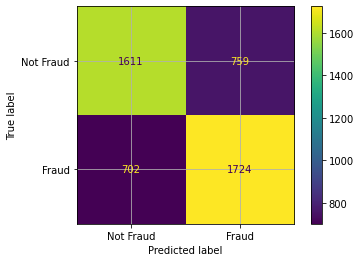

In [ ]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy',max_depth=8,min_samples_leaf=4,min_samples_split=5)
decision_tree_model.fit(X_train, y_train)
y_pred = decision_tree_model.predict(X_test)

plot_confusion_matrix(decision_tree_model, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

We can see that accuracy of decision tree is slightly better than the result of default tree. This approach is very potential, but it requires a lot of time and computing power

## Overal Result

Based on the result, lightGBM model perform the best with highest accuracy in both cases. This is because the lightGBm is somewhat fine tuned while other models were not. 

# 6. Conclusion



In conclusion, the main problem that I have while working on this dataset is its imbalance. As I have mentioned multiple times, the dataset is highly imbalanced with 0.15% True labels, while the rest are False labels due to the nature of the problem. Therefore, I believe the result would be better if we had more True labeled samples. Another issue I encountered was that attributes seem not correlated with the response variables, making the models hard to learn.

### *Some other fail attempts*

First of all, during the data cleaning process, I have tried to extract information from the "transactionDateTime" attribute, for instance, day in month, day in week, month in year, or holiday, because I believe there might be some patterns like more fraud during days that closer to holidays. During the model building, I have tried to use a neural network, but it did not perform well. Beside trying different hyperparameters, I also tried to implement GridsearchCV to finetune the hyperparameters, but due to the limited computation power and time constraints, I could only test a limited number of parameters for the decision tree model and the result after that was not so good

### Future

In the future, if I have more time to work on this project, I will 
- transform the dataset better, for example, extracting "transactionDateTime" information,
- apply PCA to reduce the less related variable and make the model focus more on important features,
- work on the neural network approach and implement other classification models like SVC, KNN,
- fine tune those implemented model better.

# References

[What Is Undersampling? ](https://www.mastersindatascience.org/learning/statistics-data-science/undersampling/)

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[What is balanced accuracy?](https://statisticaloddsandends.wordpress.com/2020/01/23/what-is-balanced-accuracy/)

[A Data Science Framework: To Achieve 99% Accuracy](https://www.kaggle.com/minhdnguyen/a-data-science-framework-to-achieve-99-accuracy#Step-5:-Model-Data)

[LightGBM model](https://www.kaggle.com/kirshoff/fraud-detection-lightgbm-xgboost)

